In [1]:
# Importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sps
from sklearn.manifold import MDS as MDS1
from sklearn.manifold import Isomap
from adjustText import adjust_text

### Preprocessing the data

In [2]:
# Importing the data into pandas dataframe
df = pd.read_csv('zoo.csv')

# Normalising the "legs" column to be same order of magnitude as the rest
max_value_legs = df["legs"].max()
df['legs'] = df['legs'].divide(max_value_legs)
df = df.transpose()

# Removing 'animal name' and 'type' since not used for PCA 
preprocessed_dataframe = df.drop(axis = 0, index = ['animal name', 'type'])
df = df.transpose()

# In data_matrix:
# Columns: Data points
# Rows: Attributes
data_matrix = preprocessed_dataframe.to_numpy(dtype=float)


### Implementation of PCA

In [3]:

def PCA(data_matrix):
    # Centering the data for PCA
    centered_data_matrix = data_matrix - np.reshape(np.mean(data_matrix, axis = 1), (16,1))

    [U,S,V] = np.linalg.svd(centered_data_matrix)
    W = U[:,0:2]

    # In latent_matrix:
    # Columns: Data points
    # Rows: Attributes
    latent_data_matrix = np.tensordot(W.T, centered_data_matrix, axes = 1)
    
    return latent_data_matrix



### Implementation of MDS

In [4]:
def weighted_distance(a,b, weight_vector = np.ones(16)):
    attribute_weight_matrix = np.diag(weight_vector)
    weighted_difference = np.matmul(attribute_weight_matrix, a-b)

    return np.dot(weighted_difference,weighted_difference)

def to_dist_matrix(data_matrix, weight_vector):
    distance_matrix = np.array([[weighted_distance(a, b, weight_vector) for a in data_matrix.T] for b in data_matrix.T])
    
    return distance_matrix

def dist_to_similarity_matrix(K):
    
    # Transforming it to a similarity matrix
    n = K.shape[1]
    sum_matrix = np.ones((n,n))
    mean_rows = np.matmul(K,sum_matrix)/n
    mean_columns = np.matmul(sum_matrix, K)/n
    variance = np.matmul(sum_matrix, mean_rows)/n

    similarity_matrix = -0.5*(K - mean_rows - mean_columns + variance)

    return similarity_matrix

def MDS(similarity_matrix, n_latent_variables):
    
    [D,Q] = np.linalg.eig(similarity_matrix)
    # Ensuring that the eigenvalues are real
    D = np.real(D)
    Q = np.real(Q)
    
    # Sorting the eigenpairs after magnitude of eigenvalues
    order = np.flip(np.argsort(D))
    D = D[order]
    Q = Q[:,order]
    D = np.diag(D)
    
    # Finding the latent variables
    I = np.eye(n_latent_variables, D.shape[0])
    placeholder = np.matmul(I, np.sqrt(np.abs(D)))
    latent_data_matrix = np.matmul(placeholder, Q.T)
    
    return latent_data_matrix



In [5]:
# Using the properties of SVD to calculate the MDS
[U,S,V] = np.linalg.svd(data_matrix)

# Creating the tall singular value matrix
sigma = np.zeros((16,101))
np.fill_diagonal(sigma, S)

# In latent_matrix:
# Columns: Data points
# Rows: Attributes
latent_matrix_MDS_SVD = np.tensordot(sigma, V, axes=1)

### Implementation of Isomap

In [6]:
def to_graph_matrix(data_matrix, k_neighbours, weight_vector):
    """
    Computing the graph matrix of the data, connecting the k closest points
    :param data_matrix: Matrix of size (m,n) with data points as columns and attributes as rows
    :param k_neighbours: Number of connected neighbours in the resulting graph
    :return: graph matrix of size (n,n)
    """
    graph_matrix = to_dist_matrix(data_matrix, weight_vector)
    
    # Marking neighbours further away than "k_neighbours" as unobtainable
    neighbour_order = np.argsort(graph_matrix, axis=1)
    graph_matrix[neighbour_order > k_neighbours] = 0

    return graph_matrix
''
def isomap(data_matrix, k, n_latent_variables, weight_vector):
    
    graph_matrix = to_graph_matrix(data_matrix, k, weight_vector)
    shortest_path_matrix = sps.csgraph.shortest_path(graph_matrix, directed=False)
    similarity_matrix = dist_to_similarity_matrix(shortest_path_matrix)
    latent_data_matrix = MDS(similarity_matrix, n_latent_variables)

    return latent_data_matrix


### Running the Implementations

In [7]:
weight_vector = np.ones(16)
weight_vector[12] = 1
df.describe
#PCA
latent_data_matrix_PCA = PCA(data_matrix)
# Adding the latent variables to the original dataframe
df['x1_PCA'] = latent_data_matrix_PCA[0,:].T
df['x2_PCA'] = latent_data_matrix_PCA[1,:].T

# MDS
similarity_matrix = dist_to_similarity_matrix(to_dist_matrix(data_matrix, weight_vector))
latent_data_matrix_MDS = MDS(similarity_matrix, 2)
# Adding the latent variables to the original dataframe
df['x1_MDS'] = latent_data_matrix_MDS[0,:]
df['x2_MDS'] = latent_data_matrix_MDS[1,:]

# Isomap
number_of_neighbours = 30
latent_data_matrix_isomap = isomap(data_matrix, number_of_neighbours, 2, weight_vector)
# Adding the latent variables to the original dataframe
df['x1_isomap'] = latent_data_matrix_isomap[0,:]
df['x2_isomap'] = latent_data_matrix_isomap[1,:]

### Plotting the results

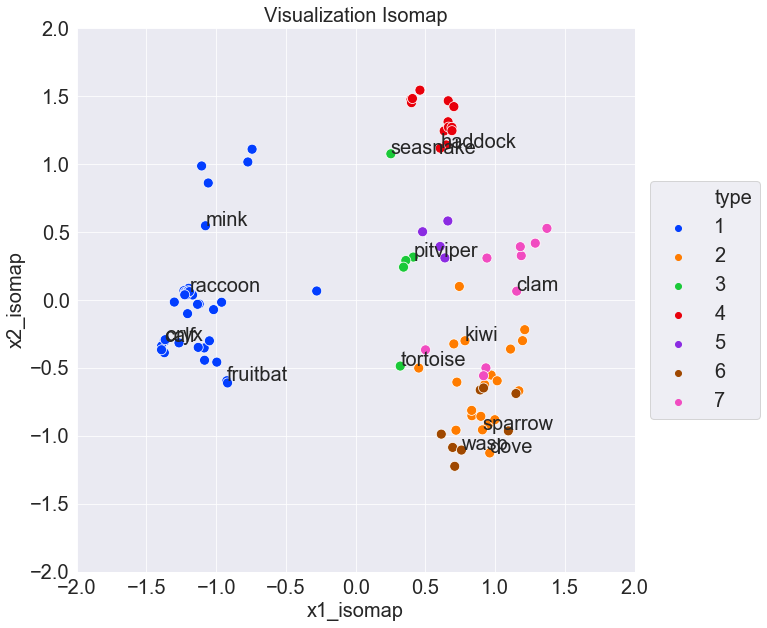

In [11]:
x1 = ['x1_PCA', 'x1_MDS', 'x1_isomap']
x2 = ['x2_PCA', 'x2_MDS', 'x2_isomap']
title = ['Visualization PCA', 'Visualization MDS', 'Visualization Isomap']

method = 2

texts = []
indicator = np.array([0 if (x + 1) % 7 == 0 else 1 for x in range(101)])
names = np.asarray(df['animal name'].copy())
names[indicator==1] = ''

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
plt.subplots_adjust(wspace=0.5)
ax = sns.scatterplot(ax=axes, x=x1[method], y=x2[method], hue='type', data=df, palette='bright', s=100)
for x, y, t in zip(df[x1[method]], df[x2[method]], names):
    texts.append(axes.text(x, y, t, fontsize=20))
    
ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1, fontsize=20)
axes.set_title(title[method])
sns.set_style('darkgrid')
plt.ylim([-2,2])
plt.xlim([-2,2])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)  
#adjust_text(texts, force_points=0.15)

plt.savefig(title[method], dpi=300,bbox_inches='tight', pad_inches=1)
plt.show()


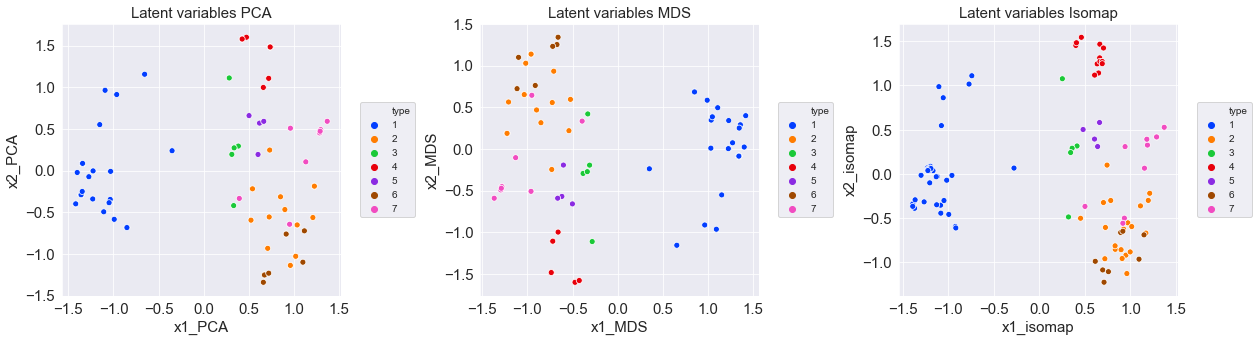

In [12]:
x1 = ['x1_PCA', 'x1_MDS', 'x1_isomap']
x2 = ['x2_PCA', 'x2_MDS', 'x2_isomap']
title = ['Latent variables PCA', 'Latent variables MDS', 'Latent variables Isomap']



fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.subplots_adjust(wspace=0.5)
for i in range(3):
    ax = sns.scatterplot(ax=axes[i], x=x1[i], y=x2[i], hue='type', data=df, palette='bright')
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
    axes[i].set_title(title[i])
    sns.set_style('darkgrid')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)  

plt.savefig('Comparison plot', dpi = 300)
plt.show()


In [38]:
preprocessed_dataframe.transpose()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1,0,0,1,0,0,1,1,1,1,0,0,0.5,0,0,1
1,1,0,0,1,0,0,0,1,1,1,0,0,0.5,1,0,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
3,1,0,0,1,0,0,1,1,1,1,0,0,0.5,0,0,1
4,1,0,0,1,0,0,1,1,1,1,0,0,0.5,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,0,0,1,0,0,0,1,1,1,0,0,0.25,1,0,1
97,1,0,1,0,1,0,0,0,0,1,1,0,0.75,0,0,0
98,1,0,0,1,0,0,1,1,1,1,0,0,0.5,1,0,1
99,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
